In [11]:
import processing
import ds
import ml
import model_saving
import TS
import TA
# Load the necessary packages and modules
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import numpy as np
import math as m
import talib
import pickle
from sklearn import svm

from hmmlearn.hmm import GaussianHMM
from sklearn.externals import joblib

In [12]:
filename_train = '/home/octo/Dropbox'+ '/SPY21Dec.csv'

### processing of data

In [13]:
data=processing.get_csv_pd(filename_train)
data=processing.BA(data)
data=processing.preprocessing_mar(data)
data_km=ml.kalman_ma(data)
data['ckm']=data.Close-data_km

In [14]:
data['rsi']=talib.RSI(np.array(data.Close.astype('float64')))
data['atr']=talib.ATR(np.array(data.High.astype('float64')),np.array(data.Low.astype('float64')),np.array(data.Close.astype('float64')),timeperiod=20)
data['mom']=talib.MOM(np.array(data.Close.astype('float64')), timeperiod=5)
data=data.dropna()
data['ret']=np.log(data.Close/data.Close.shift(300))
data['AB']=np.where(np.log(data.Close/data.Close.shift(300))>0,1,-1)# above-below. we need to predict this
data=data[8000:28000].dropna()

### Finding Up, Dn, Ud,AB frequency==Y

In [ ]:
import matplotlib.pyplot as plt
data[['Up']].plot(kind='hist', grid=True, title='Up', figsize=(2,2))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
data[['Dn']].plot(kind='hist', grid=True, title='Up', figsize=(2,2))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
data[['UD']].plot(kind='hist', grid=True, title='Up', figsize=(2,2))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
data[['AB']].plot(kind='hist', grid=True, title='Up', figsize=(2,2))
plt.show()

### Outlier as a feature

#### Anomaly Detection Using One-Class SVM
http://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html

http://scikit-learn.org/stable/modules/svm.html#svm-outlier-detection

http://users.cecs.anu.edu.au/~williams/papers/P126.pdf

http://localhost:8888/notebooks/Dropbox/trading_system/atsL2P2/L3p1_abnormal_points_model_saving.ipynb

In [15]:
data=data.dropna()

In [17]:
#outlier = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
outlier = svm.OneClassSVM(kernel="poly", degree=3, gamma="auto", coef0=4.0, tol=0.001, nu=0.3, shrinking=True, cache_size=200, verbose=False, max_iter=-1, random_state=None)
outlier.fit(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','spread','ckm', 'rsi', 'atr','mom']])

OneClassSVM(cache_size=200, coef0=4.0, degree=3, gamma='auto', kernel='poly',
      max_iter=-1, nu=0.3, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [18]:
filename_outlr = 'outlr.sav'
pickle.dump(outlier, open(filename_outlr, 'wb'))

### Markov hidden state
##### hmmlearn
https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_hmm_stock_analysis.html#sphx-glr-auto-examples-plot-hmm-stock-analysis-py

In [29]:
from hmmlearn.hmm import GaussianHMM
print("fitting to HMM and decoding ...", end="")
# Make an HMM instance and execute fit
model_hmm = GaussianHMM(n_components=5, covariance_type="full", n_iter=1000)
model_hmm.fit(data[['Volume','spread','ckm', 'rsi','UD']])

fitting to HMM and decoding ...

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-7a1df2a2c543>", line 5, in <module>
    model_hmm.fit(data[['Volume','spread','ckm', 'rsi','UD']])
  File "/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/hmmlearn/base.py", line 420, in fit
    X = check_array(X)
  File "/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py", line 433, in check_array
    array = np.array(array, dtype=dtype, order=order, copy=copy)
  File "/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/pandas/core/generic.py", line 1151, in __array__
    return _values_from_object(self)
  File "pandas/_libs/lib.pyx", line 85, in pandas._libs.lib.values_from_object
  File "/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/pandas/core/ge

KeyboardInterrupt: 

In [20]:
from sklearn.externals import joblib
joblib.dump(model_hmm, "markov_hmm.pkl")

['markov_hmm.pkl']

    filename_hmm = 'markov_hmm.sav'
    pickle.dump(model_hmm, open(filename_hmm, 'wb'))

In [ ]:
data.columns

## Loading dataset in csv. Saved from prediction notebook

In [23]:
path='/home/octo/Dropbox/for_ml_model.csv'

In [24]:
data_ml=pd.read_csv(path,sep=',',index_col=0,parse_dates=True).astype(np.float32)

In [25]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18000 entries, 2017-12-22 20:39:08.157436 to 2017-12-23 01:50:13.719414
Data columns (total 18 columns):
askPrice    18000 non-null float32
askSize     18000 non-null float32
bidPrice    18000 non-null float32
bidSize     18000 non-null float32
Open        18000 non-null float32
Close       18000 non-null float32
High        18000 non-null float32
Low         18000 non-null float32
Volume      18000 non-null float32
spread      18000 non-null float32
ckm         18000 non-null float32
rsi         18000 non-null float32
atr         18000 non-null float32
mom         18000 non-null float32
AB          18000 non-null float32
J           18000 non-null float32
h_state     18000 non-null float32
NAP         18000 non-null float32
dtypes: float32(18)
memory usage: 1.4 MB


## making dataset for AB prediction

In [26]:
X=data_ml[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']]
Y=data_ml.AB

## Prediction of +1,-1, Direction

### Tree

In [ ]:
#Import Library
#Import other necessary libraries like pandas, numpy...
from sklearn import tree
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create tree object 
model_tree = tree.DecisionTreeClassifier(criterion='gini',max_depth=3) # for classification, here you can change the algorithm as gini or entropy (information gain) by default it is gini  
# model = tree.DecisionTreeRegressor() for regression
# Train the model using the training sets and check score
model_tree.fit(X,Y)

In [ ]:
filename_tree = 'model_tree.sav'
pickle.dump(model_tree, open(filename_tree, 'wb'))

### RF

In [27]:
from sklearn.ensemble import RandomForestClassifier
SEED=7
rf = RandomForestClassifier(
    n_estimators=10,
    max_features=4,
    random_state=SEED
)

rf.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [28]:
filename_rf = 'model_rf.sav'
pickle.dump(rf, open(filename_rf, 'wb'))

## Prediction of Jump

#### making dataset for AB prediction

In [ ]:
X=data_ml[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']]
Y=data_ml.J

### Tree

In [ ]:
#Import Library
from sklearn import tree
# Create tree object 
j_tree = tree.DecisionTreeClassifier(criterion='gini',max_depth=3) # for classification, here you can change the algorithm as gini or entropy (information gain) by default it is gini  
# model = tree.DecisionTreeRegressor() for regression
# Train the model using the training sets and check score
j_tree.fit(X,Y)

In [ ]:
filename_tree = 'j_tree.sav'
pickle.dump(j_tree, open(filename_tree, 'wb'))

### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
SEED=7
rf = RandomForestClassifier(
    n_estimators=10,
    max_features=4,
    random_state=SEED
)

rf.fit(X,Y)

In [ ]:
filename_rf = 'j_rf.sav'
pickle.dump(rf, open(filename_rf, 'wb'))

## Time Series prediction

In [32]:
# magnitude of change in 300 points from last previous point
ts_df=data.Close.diff(300).dropna()[9000:9500]
ts_df=ts_df.astype('float32')

In [33]:
ts_df.head()

2017-12-21 22:46:45.545379   -0.04999
2017-12-21 22:46:46.533744   -0.04999
2017-12-21 22:46:47.530530   -0.04999
2017-12-21 22:46:48.633036   -0.05499
2017-12-21 22:46:49.904207   -0.05499
Name: Close, dtype: float32

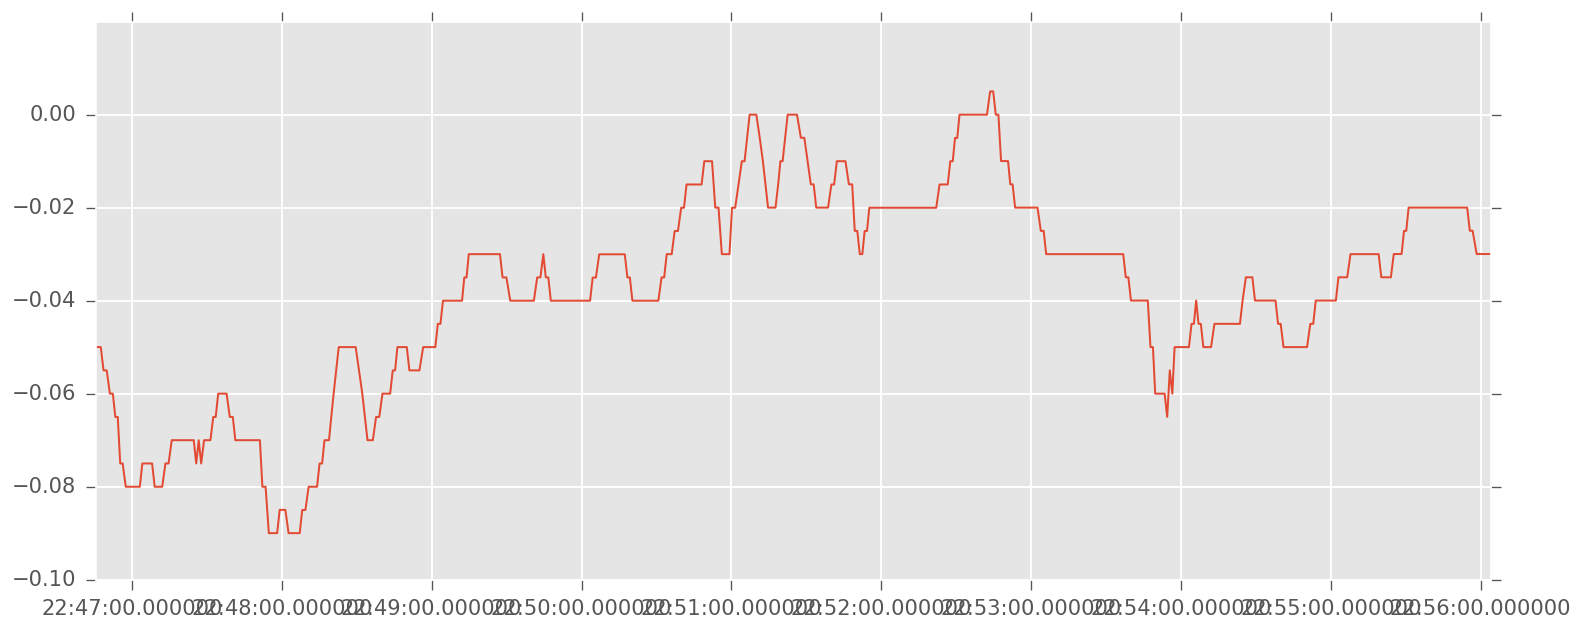

In [34]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(ts_df)
plt.show()

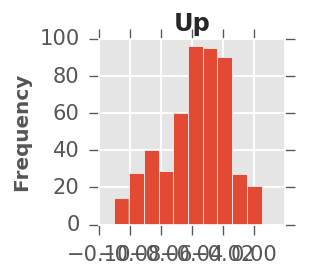

In [35]:
import matplotlib.pyplot as plt
ts_df.plot(kind='hist', grid=True, title='Up', figsize=(2,2))
plt.show()

In [36]:
%matplotlib inline
import os.path
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

In [37]:
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
import pandas as pd 

In [38]:
predict_time = 5

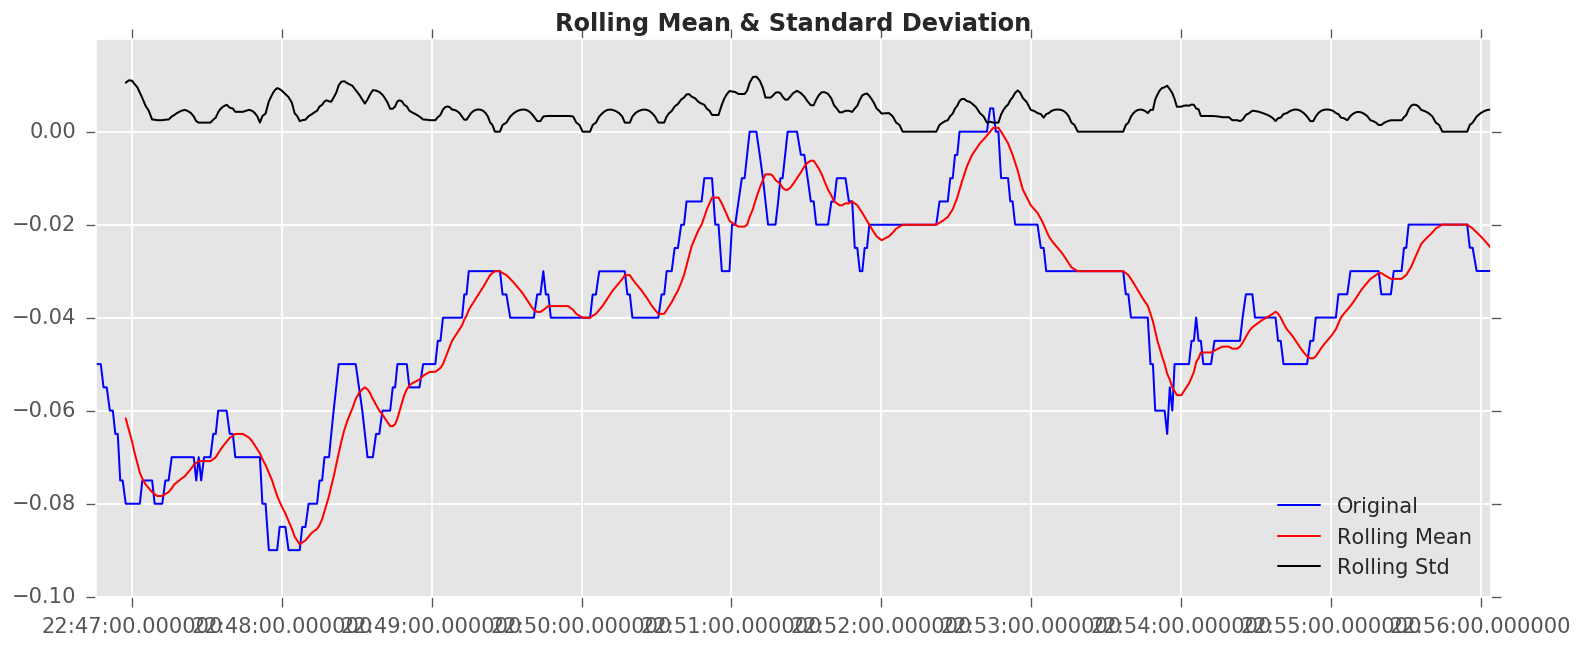

Results of Dickey-Fuller Test:
Test Statistic                 -2.16182
p-value                         0.22039
#Lags Used                     14.00000
Number of Observations Used   485.00000
Critical Value (1%)            -3.44391
Critical Value (5%)            -2.86752
Critical Value (10%)           -2.56995
dtype: float64


In [39]:
rcParams['figure.figsize'] = 15, 6
TS.test_stationarity(ts_df)
plt.show()

In [40]:
from collections import namedtuple

ADF = namedtuple('ADF', 'adf pvalue usedlag nobs critical icbest')
stationarity_results = ADF(*smt.adfuller(ts_df))._asdict()
significance_level = 0.01

if (stationarity_results['pvalue'] > significance_level):
    message = 'For p-value={:0.4f}, the time series are probably non-stationary'
    print(message.format(stationarity_results['pvalue']))
else:
    message = 'For p-value={:0.4f}, the time series are probably stationary'
    print(message.format(stationarity_results['pvalue']))

print(stationarity_results['critical'])

For p-value=0.2204, the time series are probably non-stationary
{'1%': -3.443905150512834, '5%': -2.867517732199813, '10%': -2.569953900520778}


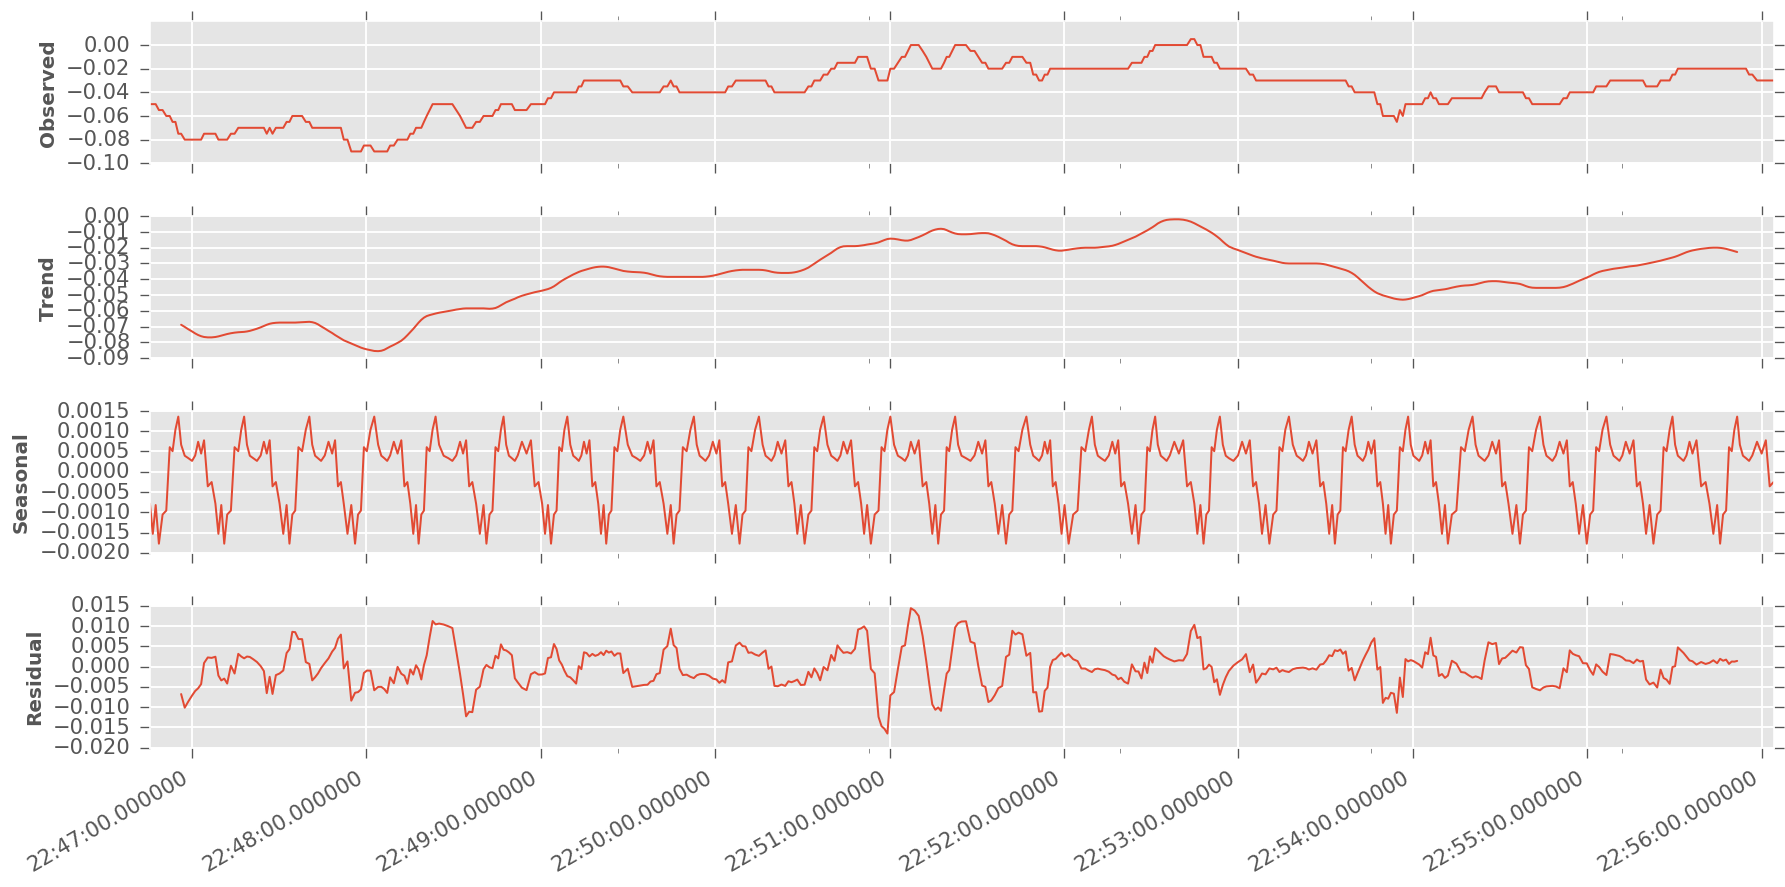

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_df, freq=20)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

In [42]:
trend = decomposition.trend
seasonal = decomposition.seasonal 
#residual = decomposition.res 

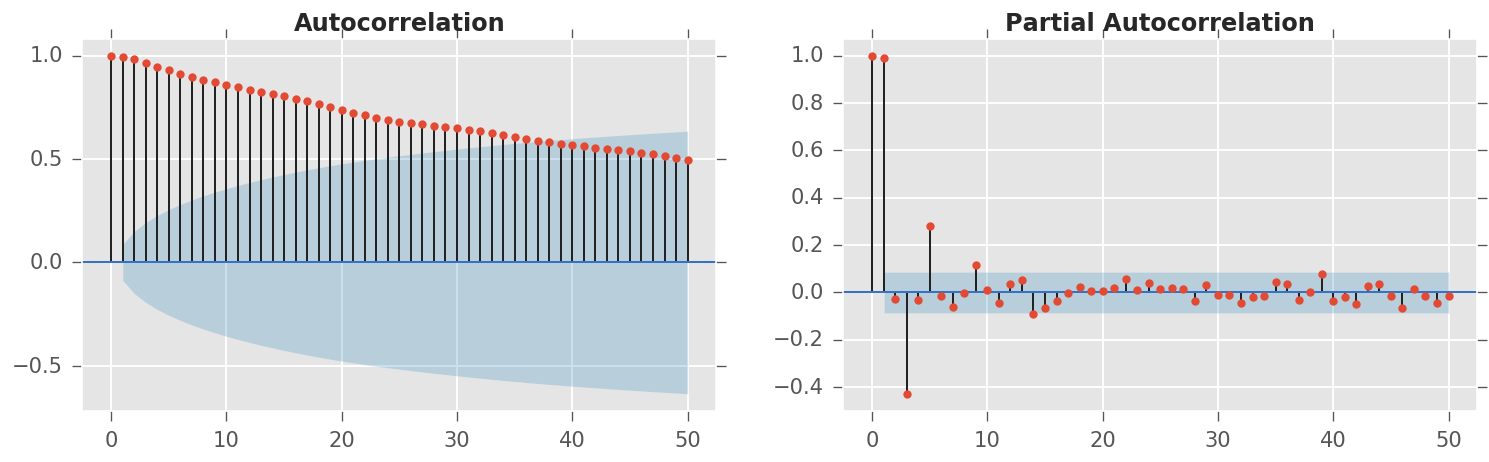

In [43]:
# rendering such a large time series is compute intensive so I'm breaking it up
didive_large_series_by = 10
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = plot_acf(ts_df,
               lags = abs(ts_df.shape[0]/didive_large_series_by),
               ax=axes[0])
fig = plot_pacf(ts_df,
                lags = abs(ts_df.shape[0]/didive_large_series_by),
                ax=axes[1])

In [44]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#from statsmodels.graphics.tsaplots import plot_pacf
#from matplotlib import pyplot as plt
import pandas
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA

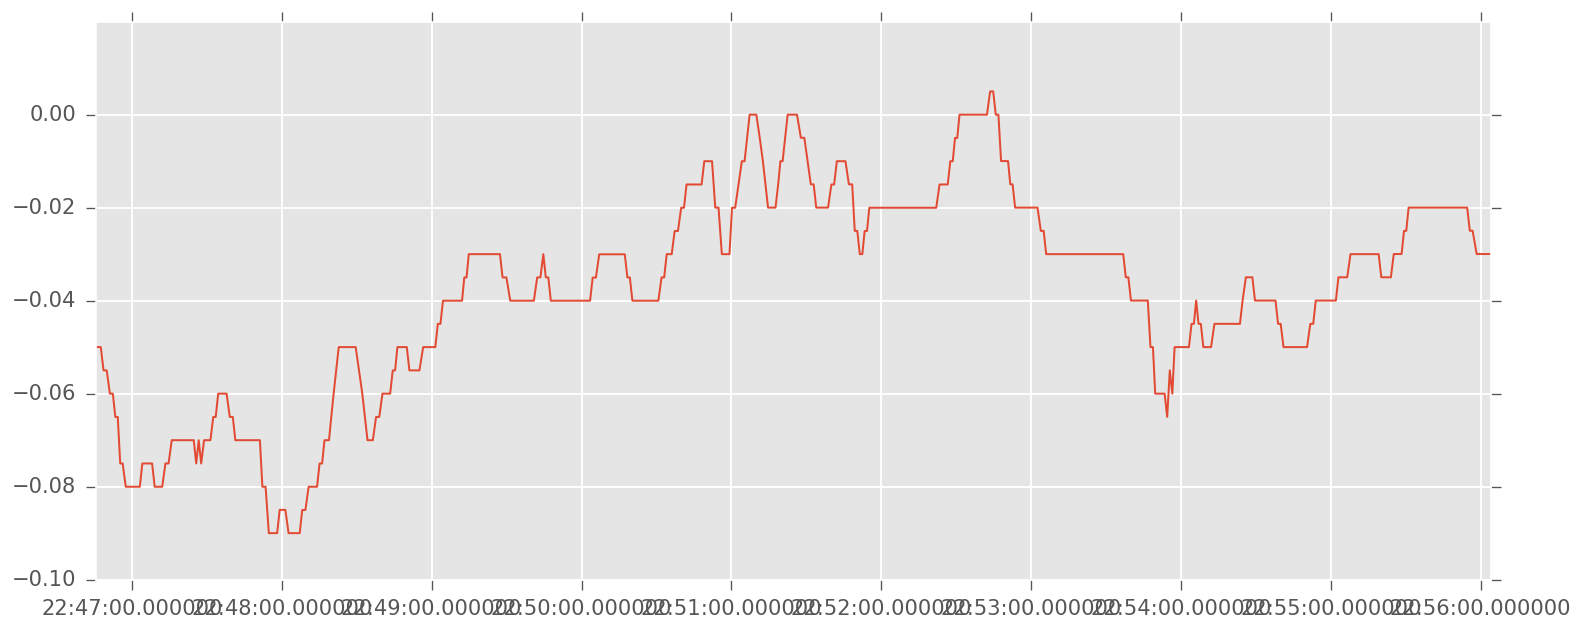

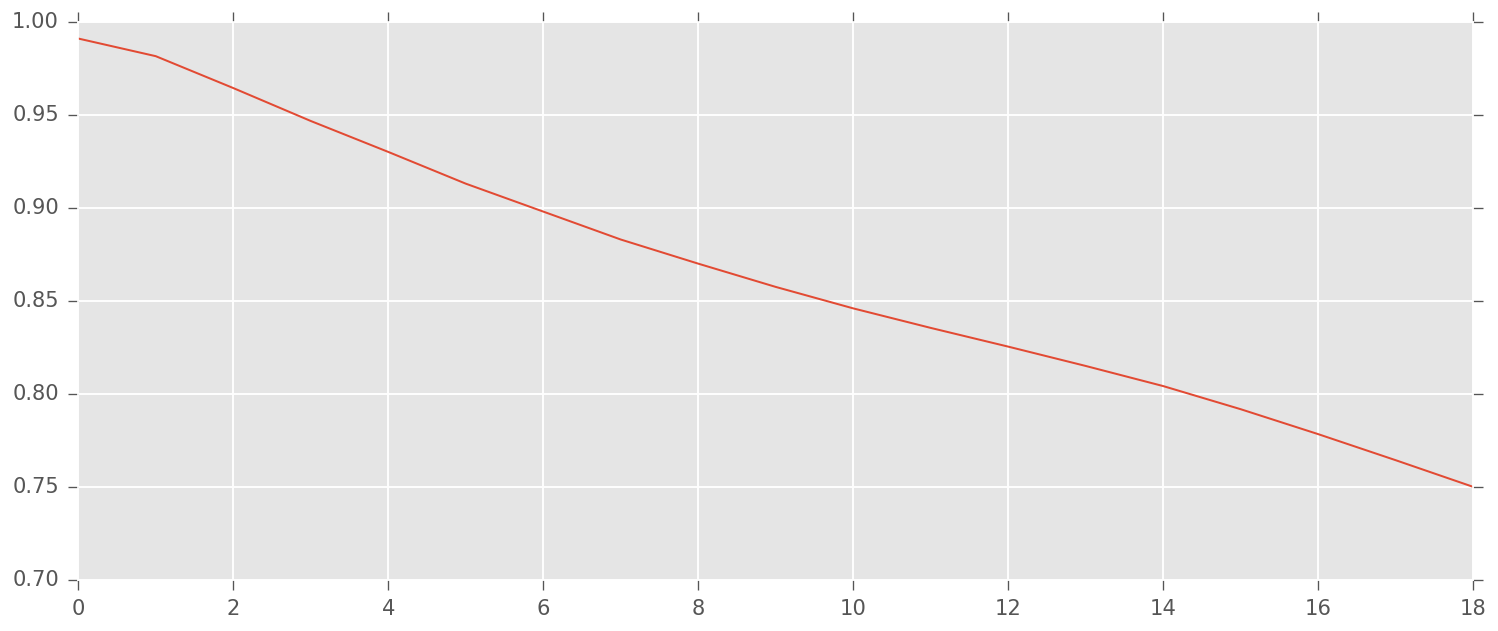

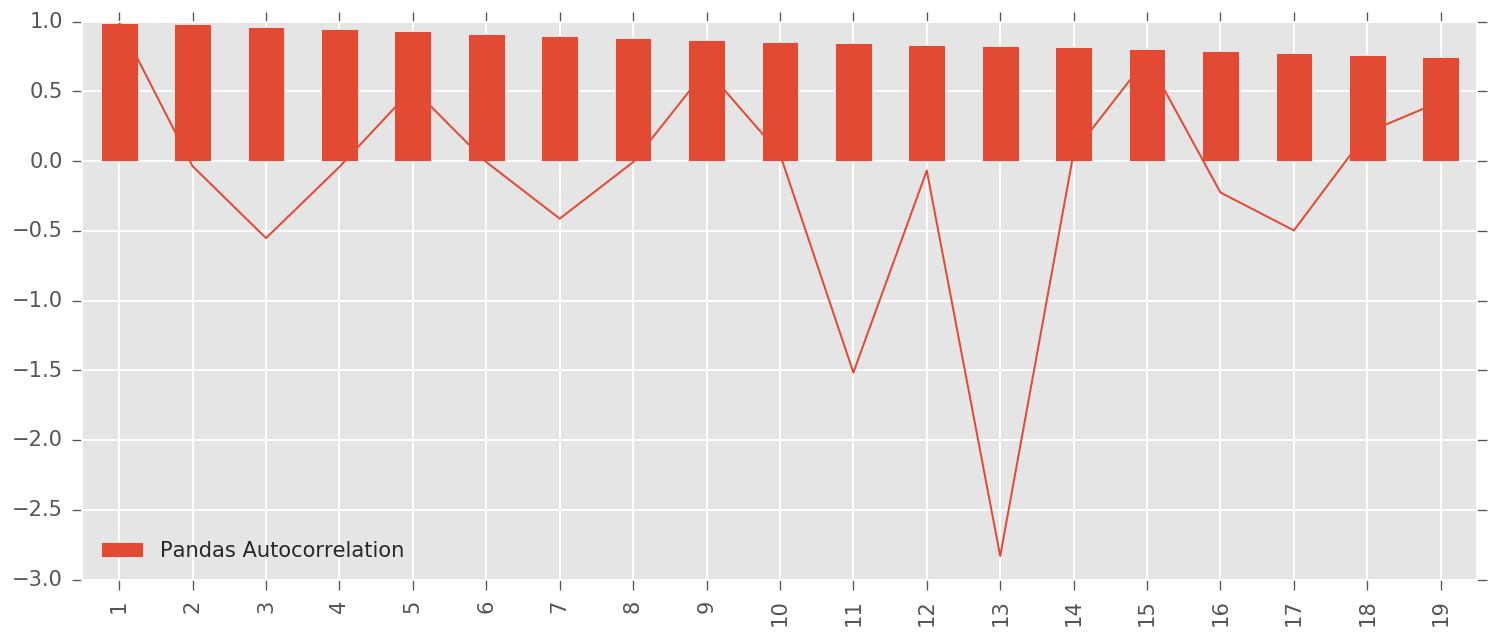

(-1.490693114145491,
 0.5381101956046452,
 0,
 499,
 {'1%': -3.4435228622952065,
  '10%': -2.569864247011056,
  '5%': -2.867349510566146},
 -4427.565103220009)

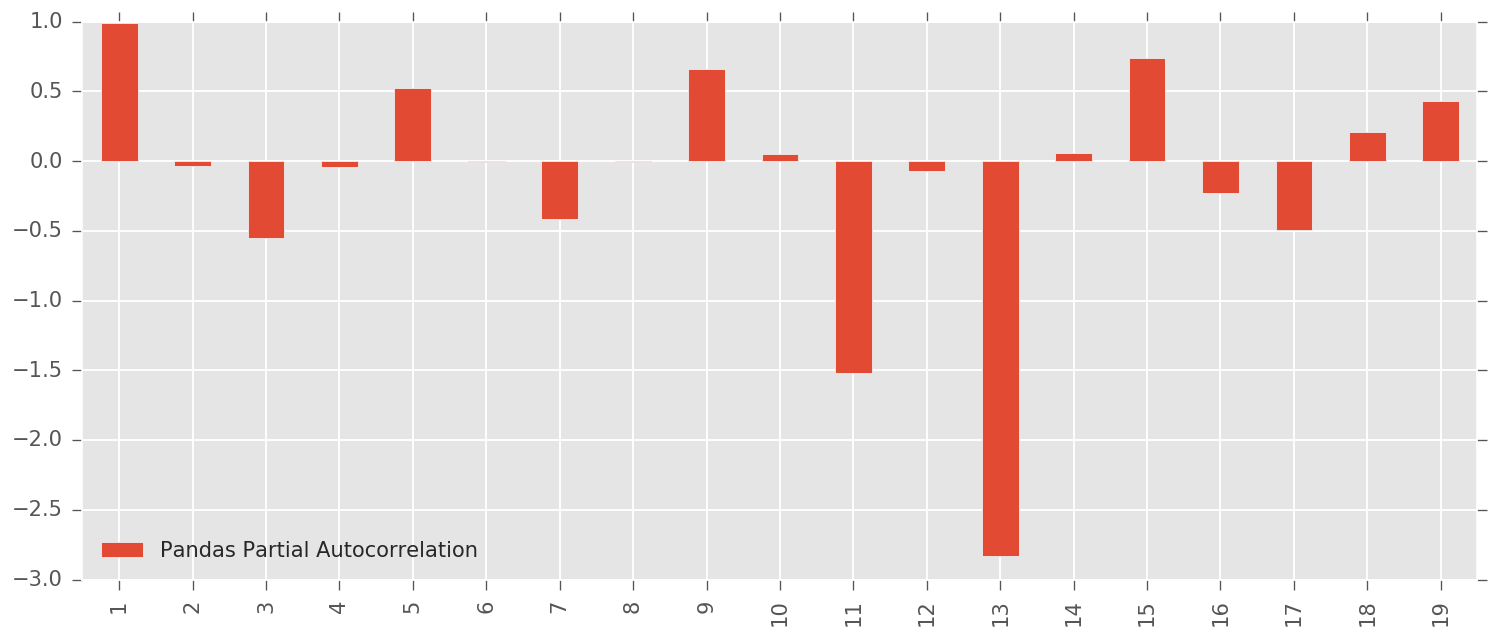

In [45]:
ret=ts_df
plt.plot(ret)
plt.show()
acf_1 =  acf(ret)[1:20]
plt.plot(acf_1)
plt.show()
test_df = pandas.DataFrame([acf_1]).T
test_df.columns = ['Pandas Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
pacf_1 =  pacf(ret)[1:20]
plt.plot(pacf_1)
plt.show()
test_df = pandas.DataFrame([pacf_1]).T
test_df.columns = ['Pandas Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
result = ts.adfuller(ret, 1)
result

In [64]:
order = (2,1,3) # if the series are stationary, there is no need for an integrated order
#mod = ARIMA(data_arima, order = order, freq = 'D')
mod = ARIMA(ts_df, order = order)
results = mod.fit()
#print(results.summary())
#print('DW test is {}'.format(sm.stats.durbin_watson(results.resid.values)))

In [66]:
mod.fit().save('arima.pkl')

In [69]:
prediction = mod.predict(ts_df.astype('double'))

In [62]:
prediction[5]

-0.06476124233759138

In [63]:
ts_df[5]

-0.05999756

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-12-21 20:39:47.126723 to 2017-12-22 03:09:33.145161
Data columns (total 19 columns):
askPrice    20000 non-null float32
askSize     20000 non-null float32
bidPrice    20000 non-null float32
bidSize     20000 non-null float32
Open        20000 non-null float32
Close       20000 non-null float32
High        20000 non-null float64
Low         20000 non-null float64
Volume      20000 non-null float32
spread      20000 non-null float32
Up          20000 non-null int64
Dn          20000 non-null int64
UD          20000 non-null int64
ckm         20000 non-null float64
rsi         20000 non-null float64
atr         20000 non-null float64
mom         20000 non-null float64
ret         20000 non-null float32
AB          20000 non-null int64
dtypes: float32(9), float64(6), int64(4)
memory usage: 2.4 MB
